<a href="https://colab.research.google.com/github/Kasimer-0/CSCI218_Group-FT32/blob/main/CNN_v0_1_(1000_Epochs)_(Clean_%2B_Tidy_%2B_Rerun).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# Imports
# ============================================

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay, \
    classification_report
from timeit import default_timer as timer
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

print("TensorFlow version:", tf.__version__)
print("TFDS version:", tfds.__version__)

import random # Import random for setting seed
# Set global random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
rng = random.Random(42) # Initialise Python's random number generator

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

TensorFlow version: 2.19.0
TFDS version: 4.9.9
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ============================================
# Enable Mixed Precision for A100/H100 GPUs (comment out if not in use)
# ============================================

from tensorflow.keras import mixed_precision

# Set the global policy to use mixed_float16
mixed_precision.set_global_policy('mixed_float16')

print('Mixed precision enabled: %s' % mixed_precision.global_policy().name)

# Verify that the policy is set
if tf.config.list_physical_devices('GPU'):
    print("GPU detected. Check policy's compute_dtype and variable_dtype for float16 use.")
else:
    print("No GPU detected, mixed precision will fall back to float32.")

# ============================================
#
# ============================================

Mixed precision enabled: mixed_float16
GPU detected. Check policy's compute_dtype and variable_dtype for float16 use.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# DATASET_PATH = '/content/drive/MyDrive/Dog dataset'
# zipped_dataset_drive_path = '/content/drive/MyDrive/Dog_dataset.zip'
# local_content_path = '/content/dog_breed_dataset'

# ============================================
# 0. Import ZIP file and extract
# ============================================

# Options selector (comment out the ones that's not being used)
# Zipped file path, change if necessary
# Define the unzip destination for the local /content directory

# ===== 50 classes option ===== #
zipped_dataset_drive_path = '/content/drive/MyDrive/CSCI218 Project/dog_breed_dataset/50_classes.zip'
local_content_path = '/content/dog_breed_dataset/50_classes'

# ===== 120 classes option ===== #
# zipped_dataset_drive_path = '/content/drive/MyDrive/CSCI218 Project/dog_breed_dataset/120_classes.zip'
# local_content_path = '/content/dog_breed_dataset/120_classes'

if os.path.exists(local_content_path):
    print(f"Dataset already extracted to {local_content_path}. Skipping extraction.")
else:
    if not os.path.exists(zipped_dataset_drive_path):
        print(f"Error: Zipped dataset not found at {zipped_dataset_drive_path}")
    else:
        # Determine the name of the zip file in /content
        zip_filename = os.path.basename(zipped_dataset_drive_path)
        copied_zip_path = os.path.join('/content/', zip_filename)

        # Copy zipped file to local /content directory
        print(f"Copying {zipped_dataset_drive_path} to /content/...")
        !cp "{zipped_dataset_drive_path}" /content/
        print("Copy complete.")

        # Unzip dataset
        print(f"Unzipping dataset to {local_content_path}...")
        # Unzip destination should be the parent directory of local_content_path
        unzip_destination_dir = os.path.dirname(local_content_path)
        os.makedirs(unzip_destination_dir, exist_ok=True) # To ensure parent directory exists

        !unzip -q "{copied_zip_path}" -d "{unzip_destination_dir}"

        # Optional clean up the copied zip file to save space
        # !rm "{copied_zip_path}"

        print("Unzipping complete.")

# Update DATASET_PATH to point to local /content directory
DATASET_PATH = local_content_path

print(f"Updated DATASET_PATH to: {DATASET_PATH}")

# ============================================
#
# ============================================

Mounted at /content/drive
Dataset already extracted to /content/dog_breed_dataset/50_classes. Skipping extraction.
Updated DATASET_PATH to: /content/dog_breed_dataset/50_classes


In [ ]:
print("\n\n\n\n\n")
print("\n" + "="*60)
print("CNN DOG BREED CLASSIFICATION")
print("")

# ============================================
# 1. Data loader
# ============================================

IMG_SIZE = 128      # SET GLOBALLY for Section 1 and Section 4          #####< GLOBAL SETTING FOR IMAGE RESIZING HERE >#####
# IMG_SIZE = 224

def load_dog_dataset(data_path, num_breeds=4, max_images_per_breed=150):
    """Load dog breed images"""

    print(f"Loading data from: {data_path}")

    if 'Images' in os.listdir(data_path):
        data_path = os.path.join(data_path, 'Images')
        print(f"Found Images folder: {data_path}")

    all_breeds = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    all_breeds.sort()

    print(f"Total breeds available: {len(all_breeds)}")

    selected_breeds = all_breeds[:num_breeds]
    print(f"\nSelected {len(selected_breeds)} breeds for classification:")
    for i, breed in enumerate(selected_breeds):
        print(f"  {i+1}. {breed}")

    images, labels = [], []
    total_loaded = 0

    for breed_idx, breed in enumerate(selected_breeds):
        breed_dir = os.path.join(data_path, breed)
        all_files = os.listdir(breed_dir)

        image_files = []
        for file in all_files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(file)

        print(f"\n{breed}:")
        print(f"  Found {len(image_files)} image files")

        loaded_count = 0
        for file in image_files[:max_images_per_breed]:
            try:
                img_path = os.path.join(breed_dir, file)

                with Image.open(img_path) as img:
                    img.verify()

                img = Image.open(img_path).convert('RGB')
                # img = img.resize((128, 128))                    # Make sure this resize option is consistent with Section 4
                img = img.resize((IMG_SIZE, IMG_SIZE))            # Based on global settings
                img_array = np.array(img)

                # if img_array.shape == (128, 128, 3):            # Make sure this resize option is consistent with Section 4
                if img_array.shape == (IMG_SIZE, IMG_SIZE, 3):    # Based on global settings
                    images.append(img_array)
                    labels.append(breed_idx)
                    loaded_count += 1
                    total_loaded += 1

                    # Removed data augmentation here; CNN pipeline will handle it
                    # flipped = np.fliplr(img_array)
                    # images.append(flipped)
                    # labels.append(breed_idx)
                    # loaded_count += 1
                    # total_loaded += 1

            except Exception as e:
                continue

        print(f"  Loaded {loaded_count} images (without augmentation, to be handled by TF pipeline)")

    print(f"\n" + "="*60)
    print(f"DATA LOADING COMPLETE")
    print(f"Total images loaded: {total_loaded}")
    print(f"Number of breeds: {len(selected_breeds)}")
    if images:
        print(f"Image shape: {images[0].shape}")
    print("="*60)

    return np.array(images), np.array(labels), selected_breeds








CNN DOG BREED CLASSIFICATION



In [ ]:
# ============================================
# 2. Load the dog dataset for CNN
# ============================================

raw_images, raw_labels, breed_names = load_dog_dataset(
    DATASET_PATH,
    num_breeds=50     # Change this accordingly to the number of breeds being used from the dataset
)

# Just in case, convert breed_names to a list if it's not already (for consistency)
class_names = list(breed_names)
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Class names:", class_names)

print(f"Total images loaded: {len(raw_images)}")

Loading data from: /content/dog_breed_dataset/50_classes
Found Images folder: /content/dog_breed_dataset/50_classes/Images
Total breeds available: 50

Selected 50 breeds for classification:
  1. n02085620-Chihuahua
  2. n02085782-Japanese_spaniel
  3. n02085936-Maltese_dog
  4. n02086079-Pekinese
  5. n02086240-Shih-Tzu
  6. n02086646-Blenheim_spaniel
  7. n02086910-papillon
  8. n02087046-toy_terrier
  9. n02087394-Rhodesian_ridgeback
  10. n02088094-Afghan_hound
  11. n02088238-basset
  12. n02088364-beagle
  13. n02088466-bloodhound
  14. n02088632-bluetick
  15. n02089078-black-and-tan_coonhound
  16. n02089867-Walker_hound
  17. n02089973-English_foxhound
  18. n02090379-redbone
  19. n02090622-borzoi
  20. n02090721-Irish_wolfhound
  21. n02091032-Italian_greyhound
  22. n02091134-whippet
  23. n02091244-Ibizan_hound
  24. n02091467-Norwegian_elkhound
  25. n02091635-otterhound
  26. n02091831-Saluki
  27. n02092002-Scottish_deerhound
  28. n02092339-Weimaraner
  29. n02093256-St

In [ ]:
# ============================================
# 3. Split the loaded data for CNN
# ============================================

# Split data into train, validation, and test sets
# First, split into training and temp (validation + test)
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    raw_images, raw_labels,
    test_size=0.4, # 40% for temp (20% val, 20% test)
    random_state=42,
    stratify=raw_labels
)

# Then, split temp into validation and test
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np,
    test_size=0.5, # 50% of temp for test, 50% for val
    random_state=42,
    stratify=y_temp_np
)

print(f"Training examples: {len(X_train_np)}")
print(f"Validation examples: {len(X_val_np)}")
print(f"Test examples: {len(X_test_np)}")

# Convert NumPy arrays to tf.data.Dataset
ds_train_raw = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
ds_val_raw = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
ds_test_raw = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np))

Training examples: 4498
Validation examples: 1499
Test examples: 1500


Displaying sample images from the augmented training dataset:


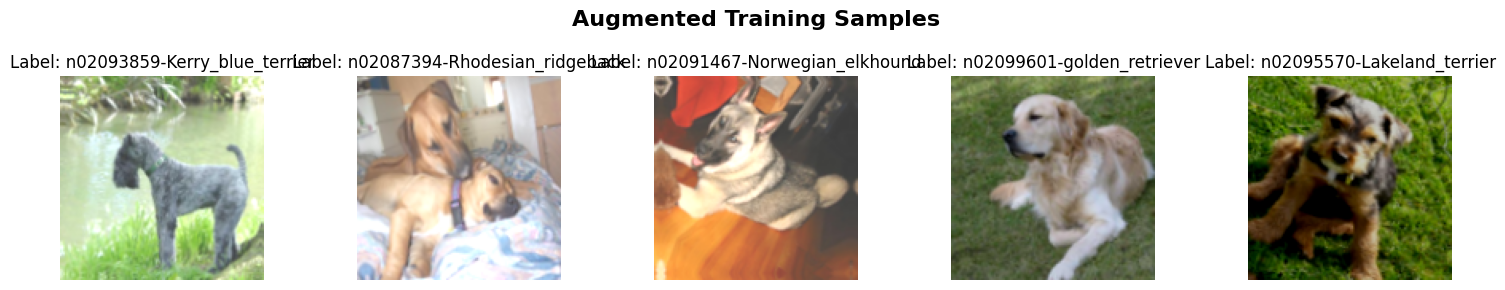


Displaying sample images from the preprocessed validation dataset:


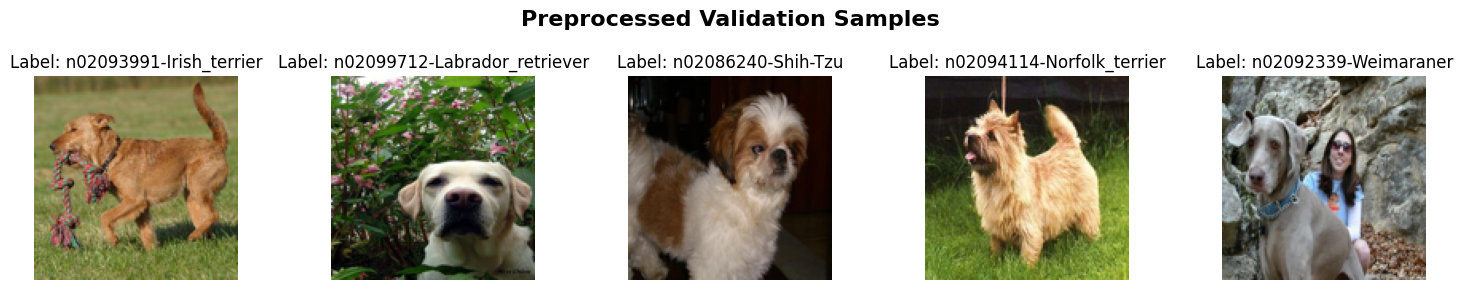


Displaying sample images from the preprocessed test dataset:


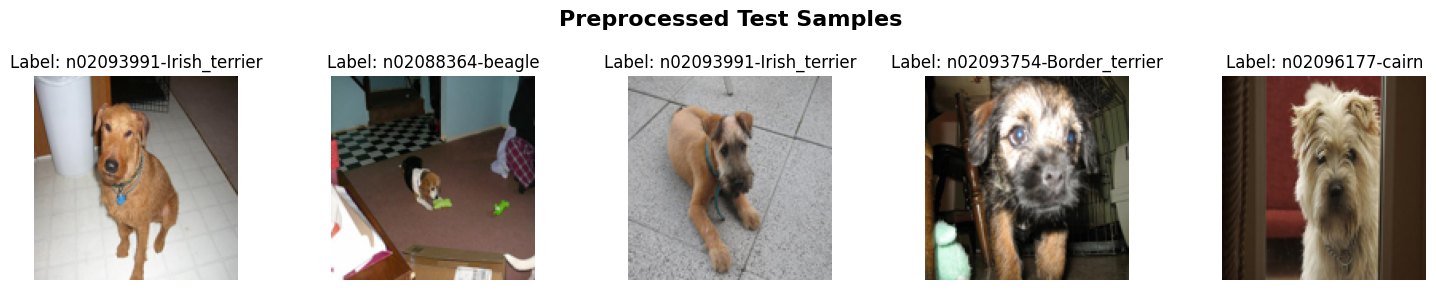

In [ ]:
# ============================================
# 4. Preprocessing and data pipeline for CNN
# ============================================

# NOTE: Global settings for IMG_SIZE is set in Section 1
# IMG_SIZE = 128    # Option 0
# IMG_SIZE = 224    # Option 1
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))      # Might be redundant
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Simple data augmentation function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.001),  # Brightness augmentation
    tf.keras.layers.RandomContrast(factor=0.001),   # Contrast augmentation
])

def augment(image, label):
    # "load_dog_dataset" already loads images resized to 128x128
    # tf.image.resize is redundant, but just for sanity check, can be commented out
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    image = tf.clip_by_value(image, 0.0, 1.0)     # CLIPPING ADDED
    return image, label

train_ds = ds_train_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = ds_val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = ds_test_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



### DISPLAYING SAMPLE IMAGES to verify data integrity ###
def display_samples(dataset, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    sample_count = 0
    for images, labels in dataset.take(1): # Take one batch
        for i in range(min(num_samples, images.shape[0])):
            ax = plt.subplot(1, num_samples, i + 1)
            # Denormalise and convert to uint8 for display
            img_display = (images[i].numpy() * 255).astype(np.uint8)
            plt.imshow(img_display)
            plt.title(f"Label: {class_names[labels[i].numpy()]}")
            plt.axis("off")
            sample_count += 1
            if sample_count >= num_samples:
                break
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()


print("Displaying sample images from the augmented training dataset:")
display_samples(train_ds, "Augmented Training Samples")

print("\nDisplaying sample images from the preprocessed validation dataset:")
display_samples(val_ds, "Preprocessed Validation Samples")

print("\nDisplaying sample images from the preprocessed test dataset:")
display_samples(test_ds, "Preprocessed Test Samples")

In [ ]:
# ============================================
# 5. Create the network architecture for CNN
# ============================================

from tensorflow.keras import layers, models

##### Training from scratch #####
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(), # Added Batch Normalization
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(), # Added Batch Normalization
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(), # Added Batch Normalization
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(), # Added Batch Normalization
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_cnn_model()
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,494,066 (9.51 MB)

 Trainable params: 2,493,106 (9.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# ============================================
# 6. Compile and train CNN
# ============================================

model.compile(
    # optimizer='adam',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Reduced learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 1000

# Training time calculation + training
start_train = timer()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

end_train = timer()

print(f"\nTraining Time: {end_train - start_train:.4f} seconds [{((end_train - start_train) / 60):.2f} minutes]")

Epoch 1/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.0215 - loss: 4.7481 - val_accuracy: 0.0200 - val_loss: 5.1739
Epoch 2/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0201 - loss: 3.9178 - val_accuracy: 0.0193 - val_loss: 4.6849
Epoch 3/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0190 - loss: 3.9122 - val_accuracy: 0.0260 - val_loss: 3.9722
Epoch 4/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0212 - loss: 3.9135 - val_accuracy: 0.0280 - val_loss: 3.9209
Epoch 5/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0229 - loss: 3.9185 - val_accuracy: 0.0220 - val_loss: 3.9101
Epoch 6/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0164 - loss: 3.9094 - val_accuracy: 0.0254 - val_loss: 3.9082
Epoch 7/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0207 - loss: 3.9120 - val_accuracy: 0.0213 - val_loss: 3.9075
Epoch 8/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0180 - loss: 3.9

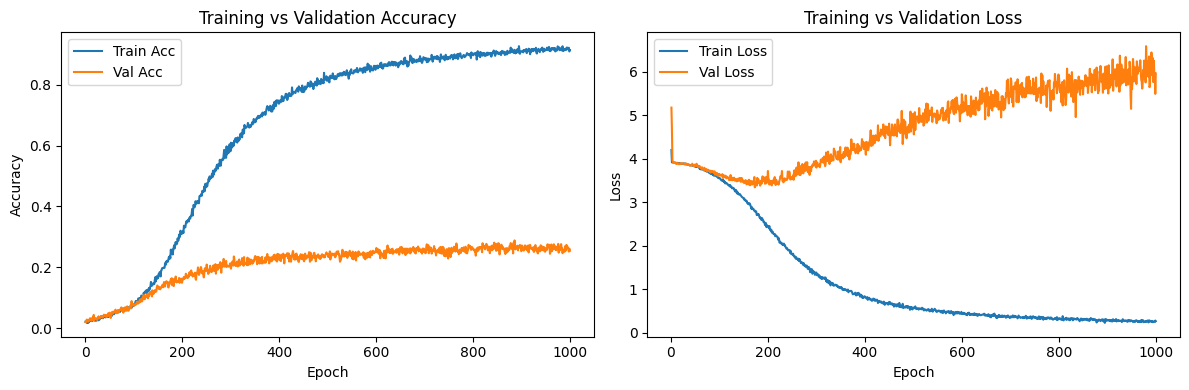

In [ ]:
# ============================================
# 7. Plot training and validation accuracy for CNN
# ============================================

history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2566 - loss: 5.5972
Test loss: 5.536224842071533
Test accuracy: 0.2693333327770233
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

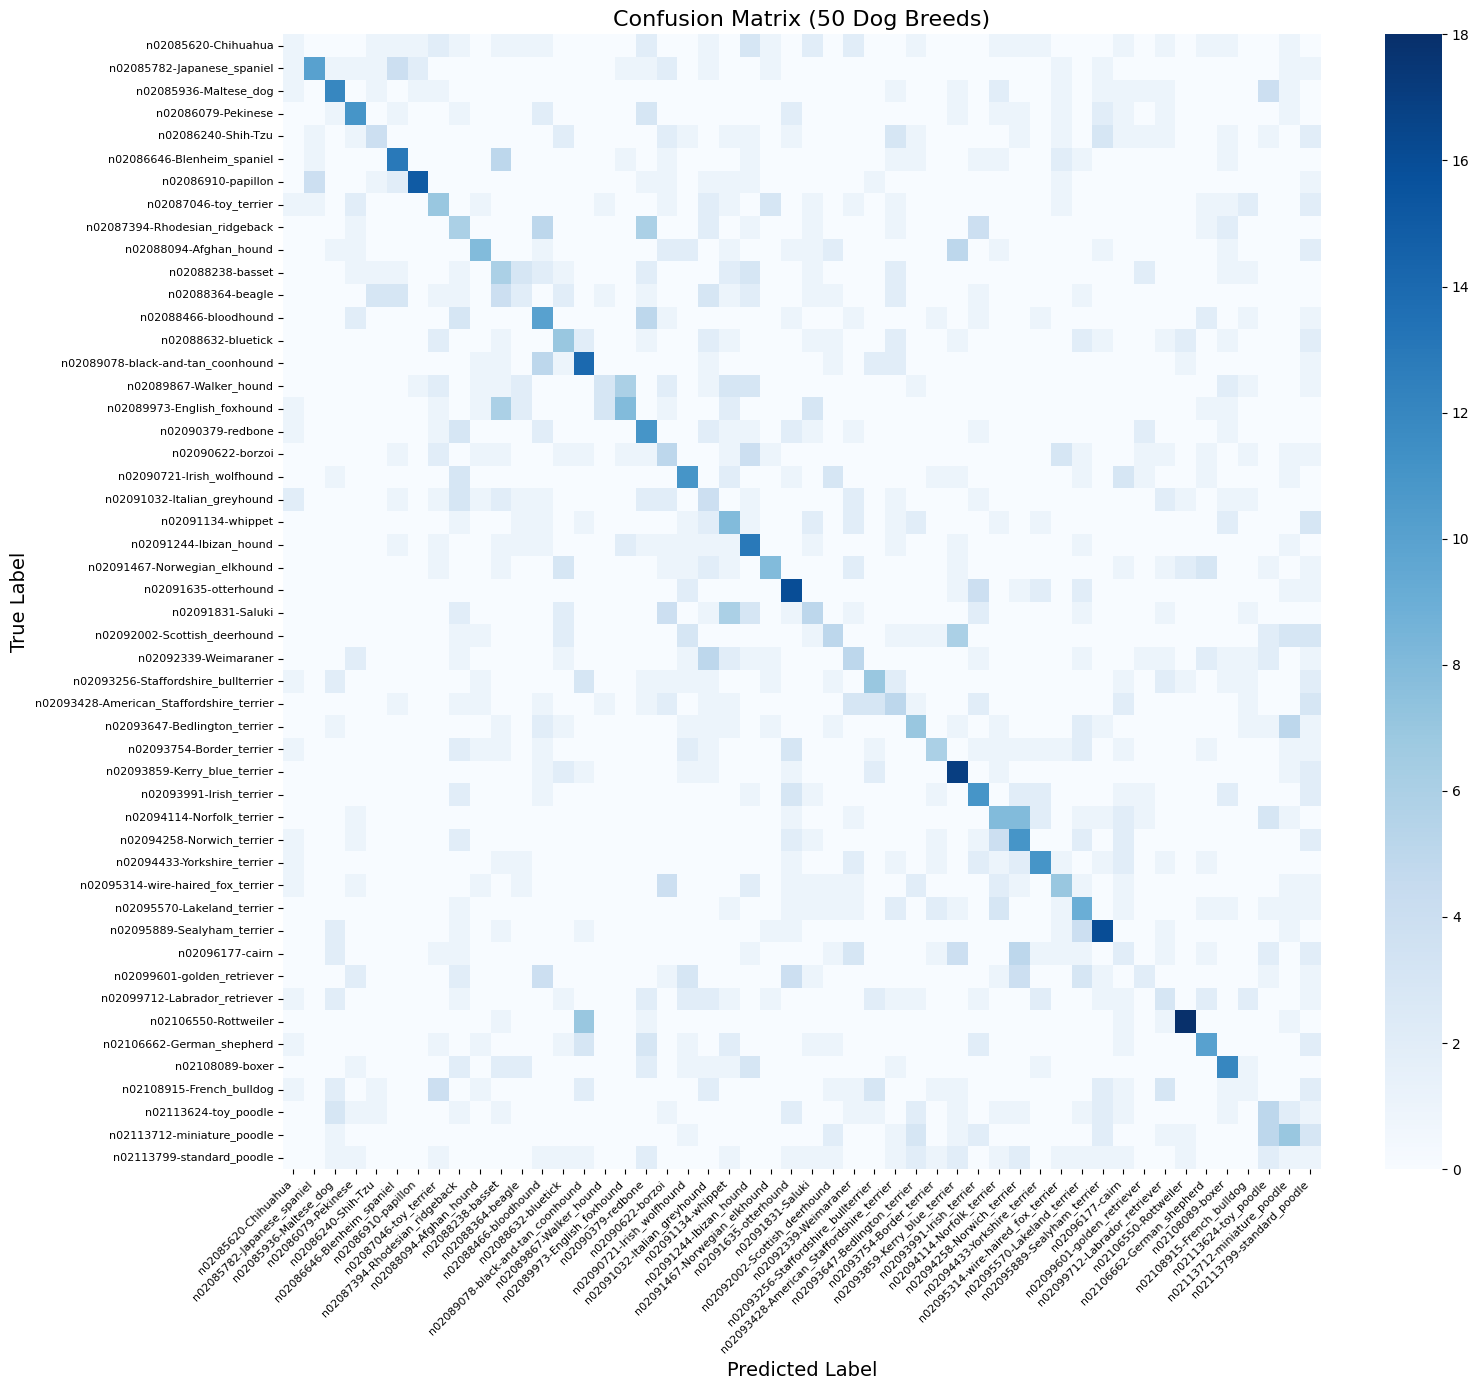

Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# ============================================
# 8. Generate Confusion Matrix for CNN
# ============================================

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix (VERSION 2)
# Note: class_names and cm are already defined

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (50 Dog Breeds)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# ============================================
# 9. Detailed Classification Report for CNN
# ============================================

# Generate a complete classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Print macro average
macro_avg = report['macro avg']
print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
      f"Recall: {macro_avg['recall']:.3f}, F1-Score: {macro_avg['f1-score']:.3f}")

# Identify the best and worst performing categories
report_df_no_summary = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
top_5_f1 = report_df_no_summary.nlargest(5, 'f1-score')
bottom_5_f1 = report_df_no_summary.nsmallest(5, 'f1-score')

print("\nTop 5 Best Performing Breeds (by F1-Score):")
print(top_5_f1[['f1-score']])

print("\nTop 5 Worst Performing Breeds (by F1-Score):")
print(bottom_5_f1[['f1-score']])

Macro Avg - Precision: 0.279, Recall: 0.269, F1-Score: 0.266

Top 5 Best Performing Breeds (by F1-Score):
                              f1-score
n02106550-Rottweiler          0.631579
n02086910-papillon            0.600000
n02095889-Sealyham_terrier    0.477612
n02093859-Kerry_blue_terrier  0.447368
n02086646-Blenheim_spaniel    0.440678

Top 5 Worst Performing Breeds (by F1-Score):
                           f1-score
n02113799-standard_poodle  0.024691
n02085620-Chihuahua        0.043478
n02108915-French_bulldog   0.043478
n02096177-cairn            0.067797
n02088364-beagle           0.085106


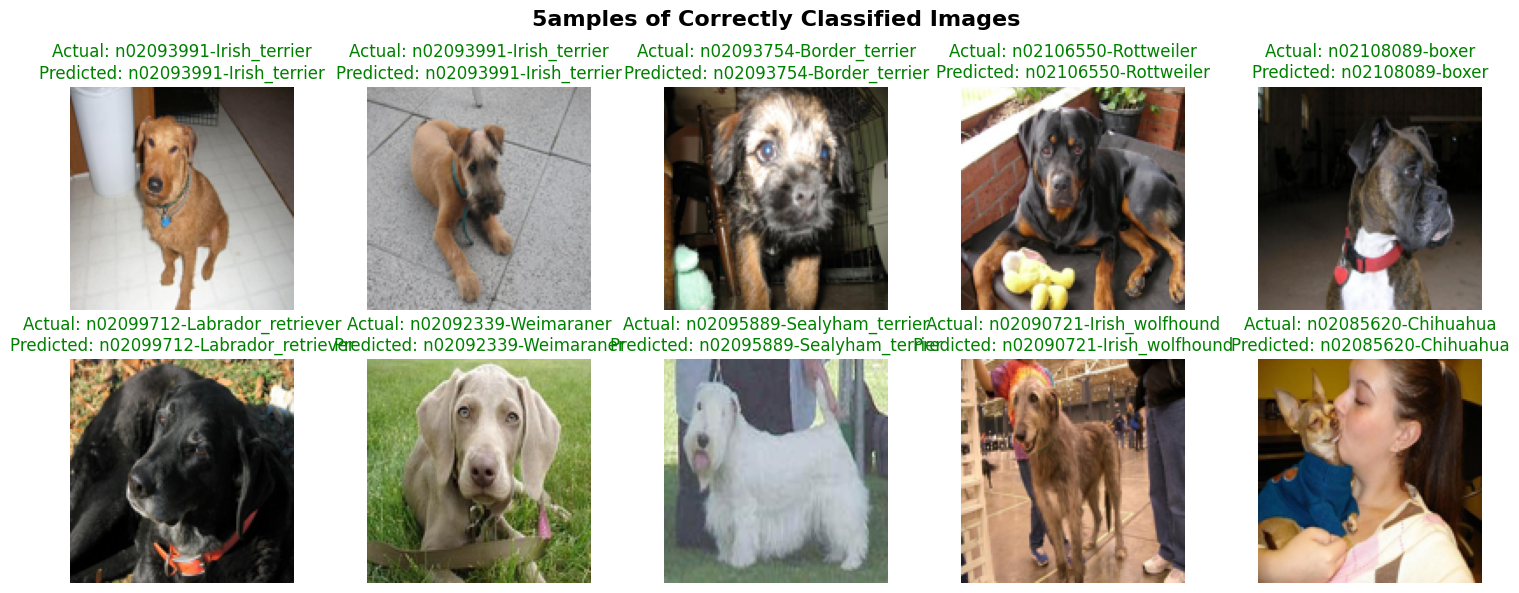

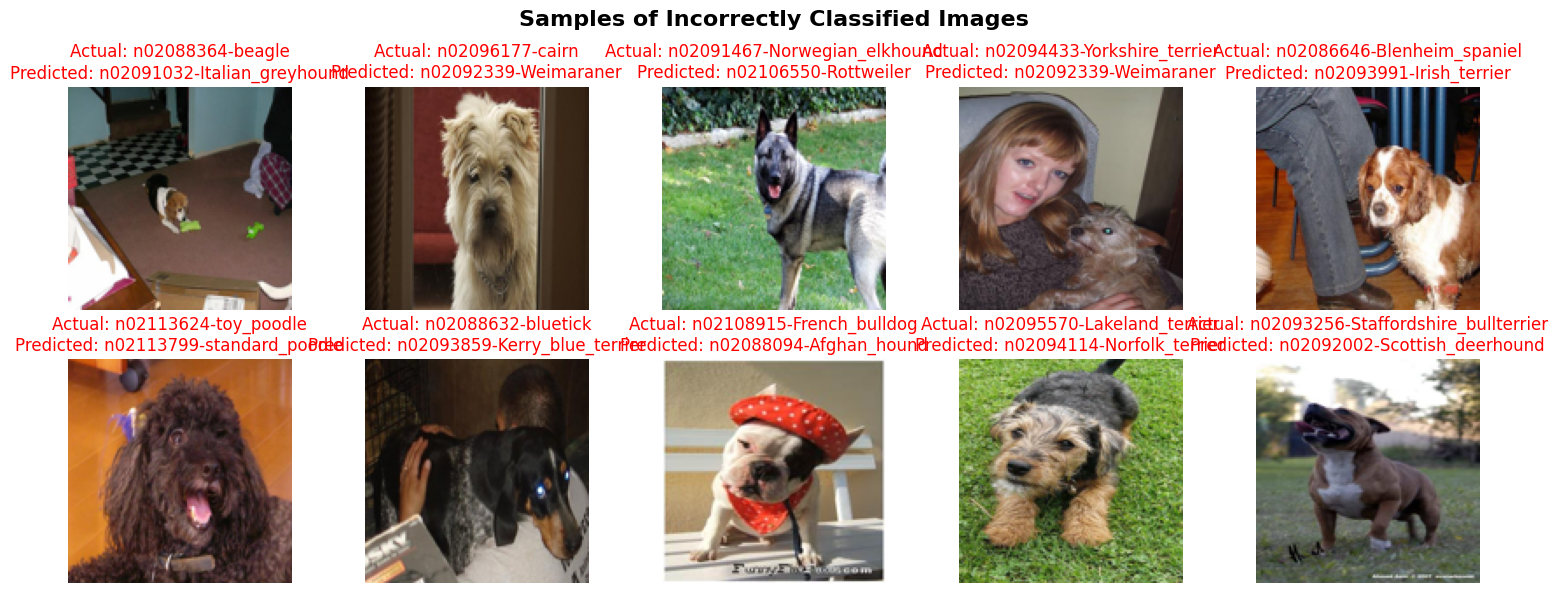

In [ ]:
# ============================================
# 10. Visualising classification sample results from the CNN
# ============================================

# sync images with labels
# unbatch the test_ds and take exactly as many images as we have labels for
test_images = []
for imgs, lbls in test_ds.unbatch().take(len(y_true)):
    test_images.append(imgs.numpy())

test_images = np.array(test_images)
y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

# identify correct and incorrect indices
# reuse the y_true and y_pred variables from evaluation/confusion matrix code above
correct_indices = np.where(y_pred_arr == y_true_arr)[0]
incorrect_indices = np.where(y_pred_arr != y_true_arr)[0]

# define amount of samples to display
DEFAULT_NUM_SAMPLES = 10                                # CHANGE THIS IF REQUIRED

def plot_images(indices, title, NUM_SAMPLES=DEFAULT_NUM_SAMPLES):
    plt.figure(figsize=(15, 6))

    COLS = 5                                    # Number of columns to display
    ROWS = (NUM_SAMPLES + COLS - 1) // COLS     # Dynamically calculate number of rows

    for i, idx in enumerate(indices[:NUM_SAMPLES]):
        plt.subplot(ROWS, COLS, i + 1)      # Dynamically adjust subplot layout
        plt.imshow(test_images[idx])

        actual = class_names[y_true_arr[idx]]
        predicted = class_names[y_pred_arr[idx]]

        # additional colour code feature: green for right, red for wrong
        title_color = 'green' if actual == predicted else 'red'

        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=title_color)    # in case if needed: ..., color=title_color)
        plt.axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_images(correct_indices, "5amples of Correctly Classified Images")
plot_images(incorrect_indices, "Samples of Incorrectly Classified Images")

In [ ]:
# ============================================
# 11. Export Trained CNN Model
# ============================================

model_save_path = '/content/drive/MyDrive/CSCI218 Project/saved_cnn_dog_breed_classifier/cnn_model.keras'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the entire model (architecture, weights, optimiser state)
model.save(model_save_path)
print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/CSCI218 Project/saved_cnn_dog_breed_classifier/cnn_model.keras


In [ ]:
# ============================================
# 12. Load Trained CNN Model Save File (for future reference)
# ============================================

from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(model_save_path)

# Verify loaded model's architecture and summary
print("Loaded model summary:")
loaded_model.summary()

# Evaluate it on the test set to ensure performance is consistent
print("Evaluating loaded model on test dataset:")
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test loss: {loaded_test_loss:.4f}")
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")

Loaded model summary:


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,480,284 (28.54 MB)

 Trainable params: 2,493,106 (9.51 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 4,986,218 (19.02 MB)

Evaluating loaded model on test dataset:
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2566 - loss: 5.5972
Loaded model test loss: 5.5362
Loaded model test accuracy: 0.2693


In [ ]:
# ============================================
# 13. Automatically Disconnect Runtime (to save computation units)
# ============================================

from google.colab import runtime

print("Attempting to unassign runtime to disconnect session...")
runtime.unassign()
print("Runtime unassign command issued. Session should disconnect shortly.")

Attempting to unassign runtime to disconnect session...
Runtime unassign command issued. Session should disconnect shortly.
